<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Flower%20Classification%20with%20TPUs/banner.png" width="1000"></center>
<br>
<center><h1>A detailed guide to custom training with TPUs - Flower Classification</h1></center>
<br>

### In this notebook, we will go through, step by step, training models with TPUs in a custom way. These includes:

* use tf.data.Dataset as input pipeline
* perform a custom training loop
* correctly define loss function
* make the custom training loop even faster
* gradient accumulation with TPUs
* apply oversampling to deal with imbalanced data
* Have fun with a special data augmentaion - Perspective transformation

This kernel is based on the following kernels with my own extension (I keep some code in these 2 notebooks):
1. [Getting started with 100+ flowers on TPU](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu) - by Martin Görner.

2. [Custom Training Loop with 100+ flowers on TPU](https://www.kaggle.com/mgornergoogle/custom-training-loop-with-100-flowers-on-tpu) - by Martin Görner.


# Table of Contents

1. [TPU or GPU detection](#hardware-detection)
2. [Competition data access](#data-access)
3. [Configuration](#configuration)
4. [Dataset functions](#dataset-functions)
  * [Read from TFRecord files - raw dataset](#read-files)
  * [Parse the raw dataset](#parse-dataset)
  * [Working with tf.data.Dataset](#working-with-datasets)
5. [Simple EDA](#simple-eda)
  * [Dataset visualizations](#visualizations)
  * [Label distribution](#label-distribution)
6. [Oversampling](#oversampling)
7. [Define the model and training process](#define-model)
 * [Model, metric and optimizer](#objects)
     - [Loss classes and reduction](#loss-functions)
 * [Distributed dataset](#distributed-dataset)
 * [Distributed computation](#distributed-computation)
    - [Optimized loops](#optimized-loops)
 * [Define the routines](#define-routines)
    - [Loss calculation](#loss-calculation)
    - [Collect the return values](#collecting) 
8. [Training](#training)
9. [Data augmentation - Perspective transformation](#perspective-transformation)
  * [Preview the effect of perspective transformation](#preview)
  * [Play with perspective transformation in JavaScript](#play-pers-trans)
  * [Implement perspective transformation in TensorFlow (batch)](#imp-pers-trans)
  * [Visualize perspective transformation](#visu-pers-trans)
10. [Conclusion](#conclusion)  

# Import

In [ ]:
import math, re, os, time
import datetime
import tensorflow as tf
import numpy as np
from collections import namedtuple, Counter
import json
from matplotlib import pyplot as plt
from matplotlib import gridspec
import itertools 
from kaggle_datasets import KaggleDatasets
import sklearn
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd

print("Tensorflow version " + tf.__version__)

from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2

# Only for tensorflow 2.3
# from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

!pip install -q efficientnet
import efficientnet.tfkeras as efn

MODEL_CLASSES = {
    'Xception': Xception,
    'DenseNet121': DenseNet121,
    'DenseNet169': DenseNet169,
    'DenseNet201': DenseNet201,
    'ResNet50V2': ResNet50V2,
    'ResNet101V2': ResNet101V2,
    'ResNet152V2': ResNet152V2,
    'InceptionV3': InceptionV3,
    'InceptionResNetV2': InceptionResNetV2,
    'EfficientNetB0': efn.EfficientNetB0,
    'EfficientNetB1': efn.EfficientNetB1,
    'EfficientNetB2': efn.EfficientNetB2,
    'EfficientNetB3': efn.EfficientNetB3,
    'EfficientNetB4': efn.EfficientNetB4,
    'EfficientNetB5': efn.EfficientNetB5,
    'EfficientNetB6': efn.EfficientNetB6,
    'EfficientNetB7': efn.EfficientNetB7,
}

import gc
gc.enable()

#### Tensorflow 2.3 and EfficientNet

With `TensorFlow 2.3` released recently, it is easier to import `EfficientNet` models. For example

```
from tensorflow.keras.applications import EfficientNetB7
```

# TPU or GPU detection<a id='hardware-detection'></a>

In order to use `TPU`, we use `TPUClusterResolver` for some initialization which is necessary to connect to the remote cluster and initialize cloud TPUs.

1. When using TPU on Kaggle, you don't need to specify arguments for `TPUClusterResolver`.
2. However, on Google Compute Engine, you need to do things like
```
    # The name you gave to the TPU to use
    TPU_WORKER = 'my-tpu-name'
    # or you can also specify the grpc path directly
    # TPU_WORKER = 'grpc://xxx.xxx.xxx.xxx:8470'
    
    # The zone you chose when you created the TPU to use on GCP.
    ZONE = 'europe-west4-a'
    
    # The name of the GCP project where you created the TPU to use on GCP.
    PROJECT = 'my-tpu-project'
    
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER, zone=ZONE, project=PROJECT)
```

Although the tf documentation says it is the project name for the argument `project`, it is actually the `Project ID` you should specify when you check on the GCP project dashboard page.

**References**:

1. [Guide - Use TPUs](https://www.tensorflow.org/guide/tpu#tpu_initialization)

2. [Doc - TPUClusterResolver](https://www.tensorflow.org/api_docs/python/tf/distribute/cluster_resolver/TPUClusterResolver)

In [ ]:
# Detect hardware, return appropriate distribution strategy

try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Competition data access<a id='data-access'></a>
TPUs read data directly from Google Cloud Storage (GCS). This Kaggle utility will copy the dataset to a GCS bucket co-located with the TPU.  Once done, use `!ls /kaggle/input/` to list attached datasets.

> Tips: If you have multiple datasets attached to the notebook, you should pass the name of a specific dataset to the `get_gcs_path()` function. (Here, the name of the dataset is the name of the directory it is mounted in.)

In [ ]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(f'GCS_DS_PATH = {GCS_DS_PATH}\n')

# you can list the bucket with "!gsutil ls $GCS_DS_PATH"
!gsutil ls $GCS_DS_PATH

# Configuration<a id='configuration'></a>

We use image size $192$ in this notebook to reduce the running time for the demonstration.

In [ ]:
# At size `512`, a GPU will run out of memory, so we use the TPU.
# For GPU training, please select 224 x 224 px image size.
IMAGE_SIZE = [192, 192] 

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
# Select the dataset containing the size we chose above
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

#### All the classes

In [ ]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 103

In [ ]:
print(f"number of flower classes: {len(CLASSES)}")

#### Visualization utilities
data -> pixels, nothing of much interest for the machine learning practitioner in this section.

In [ ]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    
    if type(data) == tuple:
        images, labels = data
    else:
        images = data
        labels = None
    
    numpy_images = images.numpy()
    
    numpy_labels = [None for _ in enumerate(numpy_images)]
    if labels is not None:
        numpy_labels = labels.numpy()
        if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
            numpy_labels = [None for _ in enumerate(numpy_images)]
    
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return '{} {}'.format(CLASSES[label], label) , True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(
        '{} {}'.format(CLASSES[label], label),
        'OK' if correct else 'NO',
        u"\u2192" if not correct else '',
        '{} {}'.format(CLASSES[correct_label], correct_label) if not correct else ''
    ), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else '{} {}'.format(CLASSES[label], label)
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    plt.close()

def get_title(label, prediction):

    title = '' if label is None else '{} {}'.format(CLASSES[label], label)
    correct = True
    if prediction is not None:
        title, correct = title_from_label_and_target(prediction, label)
    return title, correct

def display_one_flower_ax(image, label, prediction, ax, red=False, titlesize=16):

    title, correct = get_title(label, prediction)
    red = not correct
    
    ax.axis('off')
    ax.imshow(image)
    if len(title) > 0:
        ax.set_title(title, fontsize=int(titlesize) if not red else int(titlesize / 1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize / 1.5))        
        
def display_pairs_of_image_batch(databatch, databatch_2=None, predictions=None, predictions_2=None, ds_name_1=None, ds_name_2=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """

    nb_databatch = 1
    if databatch_2:
        nb_databatch = 2
    
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]

    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows        

    gs0 = gridspec.GridSpec(1, nb_databatch)
    gs00 = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=gs0[0])
    
    if databatch_2:
        images_2, labels_2 = batch_to_numpy_images_and_labels(databatch_2)
        if labels_2 is None:
            labels_2 = [None for _ in enumerate(images_2)]
        gs01 = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=gs0[1]) 

    # size and spacing
    FIGSIZE = 24.0
    SPACING = 0.10
    subplot=(rows, cols, 1)

    if rows < cols:
        fig = plt.figure(figsize=(FIGSIZE, FIGSIZE / nb_databatch / cols * rows))
    else:
        fig = plt.figure(figsize=(FIGSIZE / rows * cols, FIGSIZE / nb_databatch))
    
    if ds_name_1 and ds_name_2:
        fig.suptitle('2 batch of images. [Left: {}]   vs.   [Right: {}]'.format(ds_name_1, ds_name_2), y=-0.05, verticalalignment='bottom', fontsize=24)
    elif ds_name_1:
        fig.suptitle('1 batch of images from {}'.format(ds_name_1), y=-0.05, verticalalignment='bottom', fontsize=24)
        
    dynamic_titlesize = FIGSIZE * SPACING / max(rows, 2 * cols) * 40 + 3 # magic formula tested to work from 1x1 to 10x10 images          
        
    # display
    for row, col in itertools.product(range(rows), range(cols)):
        
        idx = row * cols + col

        image = images[idx]
        label = labels[idx]
        prediction = None if predictions is None else predictions[idx]
        ax = fig.add_subplot(gs00[row, col])
        display_one_flower_ax(image, label, prediction, ax, titlesize=dynamic_titlesize)
        
        if databatch_2:
            image = images_2[idx]
            label = labels_2[idx]
            prediction = None if predictions_2 is None else predictions_2[idx]
            ax = fig.add_subplot(gs01[row, col])
            display_one_flower_ax(image, label, prediction, ax, titlesize=dynamic_titlesize)

    #layout
    plt.tight_layout()
    
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=SPACING / 2, hspace=SPACING / 2)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    
    plt.show()
    plt.close()

# Dataset functions<a id='dataset-functions'></a>

## Read from TFRecord files - raw dataset<a id='read-files'></a>

Here we use `tf.data.TFRecordDataset` to read some TFRecord files and peek the content.

The simplest way is to specify a list of filenames (paths) of TFRecord files to it.
It is a subclass of `tf.data.Dataset`.

The raw dataset contains `tf.train.Example` messages, and when iterated over it, we get scalar string tensors.

In [ ]:
raw_dataset = tf.data.TFRecordDataset(TRAINING_FILENAMES)
raw_dataset

#### Check an element in the raw dataset

In [ ]:
serialized_example = next(iter(raw_dataset))

print('A serialized example looks like:\n\n' + str(serialized_example)[:100] + '...' * 5 + str(serialized_example)[-100:] + '\n')
print(type(serialized_example))

## Parse the raw dataset<a id='parse-dataset'></a>

The general recipe to parse the string tensors in the raw dataset is like:

1. Create a description of the features. For example:

```
    feature_description = {    
        'feature0': tf.io.FixedLenFeature([], tf.int64),
        'feature1': tf.io.FixedLenFeature([], tf.string),
        'feature2': tf.io.FixedLenFeature([], tf.float32),
        ...
    }
```

2. Define a parsing function by using `tf.io.parse_single_example` and the defined feature description.
```
    def _parse_function(example):
        """
        Args:
            example: A string tensor representing a `tf.train.Example`.
        """

        # Parse `example`.
        parsed_example = tf.io.parse_single_example(example, feature_description)
        
        return parsed_example
```

3. Map the raw dataset by `_parse_function`.
```
dataset = raw_dataset.map(_parse_function)
```

In the following cell, we apply the above recipe to our flower classification datasets.
The parsed images are `tf.string`, which are then decoded with `tf.image.decode_jpeg`.

**References**:
1. [Tutorial - TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord)

2. [Doc - TFRecordDataset](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset)

3. [Doc - tf.io.decode_jpeg](https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg)

4. [Doc - tf.io.encode_jpeg](https://www.tensorflow.org/api_docs/python/tf/io/encode_jpeg)

### what if I don't know how to define the feature description for a raw dataset ...

If you are the author who created the TFRecord files, you definitely know how to define the feature description to parse the raw dataset.

Otherwise, you can use like

```
    example = tf.train.Example()
    example.ParseFromString(serialized_example.numpy())
```

to check the information. You will get something like

```
    features {
      feature {
        key: "class"
        value {
          int64_list {
            value: 57
          }
        }
      }
      feature {
        key: "id"
        value {
          bytes_list {
            value: "338ab7bac"
          }
        }
      }
      feature {
        key: "image"
        value {
          bytes_list {
            value: .......
```
This should give you enough information to define the feature description.

In [ ]:
example = tf.train.Example()
example.ParseFromString(serialized_example.numpy())
print(str(example)[:300] + ' ...')

Here is how we parse a serialized example in this flower classification dataset and obtain an image.

In [ ]:
def decode_image(image_data):
    """
    Args:
        image_data: A `tf.string` obtained from `tf.io.encode_jpeg()`.
    """
    
    # image is now of type `tf.uint8`
    image = tf.image.decode_jpeg(image_data, channels=3)
    
    # convert image to floats in [0, 1] range
    image = tf.cast(image, tf.float32) / 255.0  
    
    # explicit size needed for TPU
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) 
    
    return image

def read_labeled_tfrecord(example):
    
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    parsed_example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(parsed_example['image'])
    label = tf.cast(parsed_example['class'], tf.int32)
    
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    parsed_example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(parsed_example['image'])
    idnum = parsed_example['id']
    
    return image, idnum # returns a dataset of (image, id) pairs

In [ ]:
parsed_example = read_labeled_tfrecord(serialized_example)
print('A parsed example looks like\n\n' + str(parsed_example)[:200] + '\n...')

## Working with tf.data.Dataset<a id='working-with-datasets'></a>

With the above parsing methods defined, we can define how to load the dataset with more options and further apply shuffling, bacthing, etc. In particular:


* Use `num_parallel_reads` in `tf.data.TFRecordDataset` to read files in parallel.
* Set `tf.data.Options.experimental_deterministic=False` and use it to get a new dataset that ignores the order of elements.
* Use `num_parallel_calls` in `tf.data.Dataset.map()` method to have parallel processing.
* Use `tf.data.Dataset.prefetch()` to allow later batches to be prepared while the current batch is being processed.

The parallel processing and prefetching are particular important when working with TPU. Since TPU can process batches very quickly, the dataset pipeline should be able to provide data for TPU efficiently, otherwise the TPU will be idle.

**References**:
1. [Guide - tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
2. [Guide - Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)
3. [Doc - Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    """Read from TFRecords.
    
    For optimal performance, reading from multiple files at once and disregarding data order (if `ordered=False`).

    Order does not matter since we will be shuffling the data anyway (for training dataset).
    """

    options = tf.data.Options()
    if not ordered:
        # disable order, increase speed
        options.experimental_deterministic = False

    # Read in an automatically interleaving way from multiple tfrecord files.
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE)
    
    # Uses data as soon as it streams in, rather than in its original order.
    dataset = dataset.with_options(options) 
    
    # parse and return a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    dataset = dataset.map(
        read_labeled_tfrecord if labeled else read_unlabeled_tfrecord,
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    
    return dataset

def get_training_dataset(batch_size, shuffle_buffer_size, repeat_dataset=False, ordered=False, drop_remainder=True):
    """
    Set `shuffle_buffer_size` to `1` to have no shuffling.
    """
    
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, ordered=ordered)
    
    # Repeat the training dataset. We will determine the number of steps (or updates) later for 1 training epoch.
    if repeat_dataset:
        dataset = dataset.repeat()
    
    # Shuffling
    if not ordered:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    # Batching
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    
    # prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

def get_validation_dataset(batch_size):
    
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

def get_test_dataset(batch_size):
    
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) 
    
    return dataset

def count_data_items(filenames):
    # For this flower dataset, the number of data items is written in the name of .tfrec files.
    # For example, `flowers00-230.tfrec` means 230 data items in it.
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

ORIGINAL_NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Original Dataset:\n\n{} training images\n{} validation images\n{} unlabeled test images'.format(ORIGINAL_NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

### Check what a batch looks like<a id="check-batch"></a>

#### Info about a train dataset

In [ ]:
ds = get_training_dataset(batch_size=3, shuffle_buffer_size=1)
ds

#### A train batch

In [ ]:
batch = next(iter(ds))
print('The batch is a {} with {} components.'.format(type(batch).__name__, len(batch)))
print('\nThe 1st compoent is a {} with shape {}'.format(type(batch[0]).__name__, batch[0].shape))
print('The 2nd compoent is a {} with shape {}\n'.format(type(batch[1]).__name__, batch[1].shape))

print('The 2nd compoent looks like')
batch[1]

#### Info about a test dataset

In [ ]:
ds = get_test_dataset(batch_size=3)
ds

#### A test batch

In [ ]:
batch = next(iter(ds))
print('The batch is a {} with {} components.'.format(type(batch).__name__, len(batch)))
print('\nThe 1st compoent is a {} with shape {}'.format(type(batch[0]).__name__, batch[0].shape))
print('The 2nd compoent is a {} with shape {}'.format(type(batch[1]).__name__, batch[1].shape))

print('\nThe 2nd compoent looks like')
batch[1]

# Simple EDA<a id='simple-eda'></a>

In this EDA section, we create datasets of batch size 16. These are only used for visualizations and for getting some statistics about the datasets. Later, we will create actual datasets for training, validation and testing.

## Dataset visualizations<a id='visualizations'></a>
### Let's look some samples from the train/validation/test datasets.

### Training samples

In [ ]:
# Peek the training data
train_dataset = get_training_dataset(batch_size=16, shuffle_buffer_size=1, ordered=True, drop_remainder=False)
train_iter = iter(train_dataset)

In [ ]:
# run this cell again for next set of images
batch = next(train_iter)
display_batch_of_images(batch)

### Validation samples

In [ ]:
# peek the validation data
valid_dataset = get_validation_dataset(batch_size=16)
valid_iter = iter(valid_dataset)

In [ ]:
# run this cell again for next set of images
display_batch_of_images(next(valid_iter))

### Testing samples

In [ ]:
# peek the test data
test_dataset = get_test_dataset(batch_size=16)
test_iter = iter(test_dataset)

In [ ]:
# run this cell again for next set of images
display_batch_of_images(next(test_iter))

## Number of dataset examples

In [ ]:
print('Original Dataset:\n\ntraining images: {}\nvalidation images: {}\ntest images {}'.format(ORIGINAL_NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

## Label distribution<a id="label-distribution"></a>

### Get labels and counting

We use 
```
@tf.autograph.experimental.do_not_convert
```
to tell tensorflow not to convert the function `get_label_counting`, otherwise we get the following warning
> WARNING: AutoGraph could not transform <function get_label_counting.<locals>.<lambda> at 0x7f0690681830> and will run it as-is.

This is OK, because this function is not used in our input pipeline, so not converting it to graph won't slow down the pipeline.

In [ ]:
@tf.autograph.experimental.do_not_convert
def get_label_counting(labeled_dataset):
    
    c = Counter()
    labels = []
    for batch in labeled_dataset.map(lambda image, label: label, num_parallel_calls=tf.data.experimental.AUTOTUNE):
        labels.append(batch)
    
    labels = tf.concat(labels, axis=0).numpy()
    c.update(labels)

    return labels, c

In [ ]:
train_labels, train_counter = get_label_counting(train_dataset)
valid_labels, valid_counter = get_label_counting(valid_dataset)

### Plot label distribution

In [ ]:
def plot_label_dist(labels, dist_1, dist_2, dist_label_1, dist_label_2, title=''):
    
    x = np.arange(len(labels)) # the label locations
    width = 0.4 # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 5))
    rects1 = ax.bar(x - width / 2, dist_1, width, label=dist_label_1)
    rects2 = ax.bar(x + width / 2, dist_2, width, label=dist_label_2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('portion in dataset')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels([str(x) if x % 5 in [0] else '' for x in range(len(labels))] )
    ax.legend()

    plt.show()
    plt.close()

In [ ]:
labels = list(range(len(CLASSES)))
dist_train = [train_counter[x] / ORIGINAL_NUM_TRAINING_IMAGES for x in labels]
dist_valid = [valid_counter[x] / NUM_VALIDATION_IMAGES for x in labels]    
    
half = len(labels) // 2
plot_label_dist(
    labels[:half],
    dist_train[:half],
    dist_valid[:half],
    'Train',
    'Valid',
    title='Label distribution in Train/Valid datasets: Labels 0-{}'.format(half - 1)
)

plot_label_dist(
    labels[half:],
    dist_train[half:],
    dist_valid[half:],
    'Train',
    'Valid',    
    title='Label distribution in Train/Valid datasets: Labels {}-{}'.format(half, len(labels) - 1)
)

From the above label distribution plots for training and validation datasets, we see that the distributions are almost identical. However, the labels are very imbalanced. This leads to the next section - Oversampling - to deal with such case.

# Oversampling<a id='oversampling'></a>

Here are 2 common techniques for dealing with imbalanced data:

* Class weights
    
    This makes the classifier weight more on those examples with labels in the minority classes. 


* Oversampling

   The idea is to extend the dataset by repeating the examples in the minority classes.
   
Here is a quote from [Classification on imbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data):
  
> If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.  
> But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient   signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

In this notebook, we decide to focus on applying oversampling and compare it to training without oversampling.
The comparison between class weights and oversampling could be found in the reference.

**References:** 

1. [Tutorial - Classification on imbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

## Step 1: Review the number of occurrence of each class

We use the counter `train_counter` computed in the [Label distribution](#label-distribution) subsection.

In [ ]:
print("labels in the original training dataset, sorted by occurrence\n")
print("pairs of (class id, counting)\n")
print(train_counter.most_common())

## Step 2: Determine how many times an example in a class should repeat

The objective of our approach is to have a (more) balanced dataset, where the number of occurrence of each class is much closer to those of other classes than it is in the original training dataset.

From the above counting, we see that the majority class is class 67 which occurs 782 times, while the minority classes are class 44, 34 and 6, which occur 18 times each.  

For a given number $N$, we will construct a new dataset where each class occurs approximately $N$ times. For example, if we specify $N = 782$, the new dataset will have about $782$ examples for each class, which is clearly balanced.

For the flexbility of our experiments, we allow $N$ to be lower, say, `100` or `300`. These still give imbalanced dataset, but less imbalanced than the original dataset.

Given a such number $N$ and a class $y$, for any training example $\mathbb{x}$ in the original dataset with label $y$, we now determine the number of times the example $\mathbb{x}$ should repeat in order to obtain a dataset having the property discussed in the prevous paragraphs.
At a first attempt, this will be a float number, which is the ideal value. Based on it, the actual number of times the example $\mathbb{x}$ will repeat is determined in a randomized way to make the number of occurrences of each class roughly $N$. For example, if examples in class $y$ should repeat $2.7$ times, then they will repeat $2$ times with a probability $0.3$ and $3$ times with a probability $0.7$.

In [ ]:
def get_num_to_repeat_for_class(class_id, target_counting):
    """Compute the (ideal) number of times a training example with
       label `class_id` should repeat in order to get a dataset where
       each class occur `target_counting` times.
       
    The return value is a float number. The actual number to repeat will
    be determined in the function `get_nums_to_repeat` in a randomized way,
    in order to make a better approximation.
       
    Args:
    
        class_id: int, the id of a class.
        target_counting: int, the targeted occurrence number.
        
    Returns:
        A float, the number of times an example with label `class_id` to repeat.
    """
    
    # Use the counter computed in `Label distribution` subsection`.
    counting = train_counter[class_id]
    
    # No need to repeat for a class having already the desired occurrecne.
    if counting >= target_counting:
        return 1.0
    
    num_to_repeat = target_counting / counting
    
    return num_to_repeat

def get_nums_to_repeat(target_counting):
    """Compute a tabel that stores the results of `get_num_to_repeat_for_class`
       for every class and for the given `target_counting`.
    
    Args:
        target_counting: int, the targeted occurrence number.
    
    Returns:
        table: A `tf.lookup.StaticHashTable`.
        d: A dictionary storing the same information as `table`.
    """
    
    keys = range(len(CLASSES))
    values = [get_num_to_repeat_for_class(x, target_counting) for x in keys]

    keys_tensor = tf.constant(keys)
    vals_tensor = tf.constant(values)
    
    table_initializers = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
    table = tf.lookup.StaticHashTable(table_initializers, default_value=0.0)
    
    d = {k: v for k, v in zip(keys, values)}

    return table, d

def get_num_to_repeat_for_example(example, table):
    """Compute the actual number of times a training example will repeat
       in order to get a dataset where each class occur <approximately> 
       N times with N being a pre-defined number that is used for constructing
       `table`.

    Args:
        example: A tuple of 2 tensors, which is a labeled training example and
            represented as (image, label).
                          
        tabel: A tf.lookup.StaticHashTable, as obtained from `get_nums_to_repeat`.
                          
    Returns:
        A tf.int64 scalar tensor, the number of times `example` will repeat.
    """
    
    image, label = example

    num_to_repeat = table.lookup(label)    
    
    # This part is deterministic.
    num_to_repeat_integral = tf.cast(int(num_to_repeat), tf.float32)
    
    # With a probability `residue`, we allow `example` to repeat one more time.
    residue = num_to_repeat - num_to_repeat_integral
    num_to_repeat = num_to_repeat_integral + tf.cast(tf.random.uniform(shape=()) <= residue, tf.float32)
    
    return tf.cast(num_to_repeat, tf.int64)

#### A remark about using tf.lookup.StaticHashTable

Here we use `tf.lookup.StaticHashTable` instead of a python dictionary because the dataset transformations involve tensorflow tensors which are not hashable.

### Let's check the number of times an example should repeat

Here, we take $N = 782$.

In [ ]:
_, d = get_nums_to_repeat(782)
d = sorted(d.items(), key=lambda x: x[1], reverse=True)

print('pair of (class id, num to repeat)\n')
for x in d:
    print(x)

## Step 3. A method to get oversampled datasets

Now we are ready to define a method that can return oversampled datasets.

There is an argument `augmentation_fn` that won't be used for now. After we define our own data augmentation method in [Data augmentation - Perspective transformation](#perspective-transformation), we can pass it to `augmentation_fn` to make the oversampled dataset having more diversity.

In [ ]:
def get_oversampled_training_dataset(
        target_counting, batch_size, shuffle_buffer_size,
        repeat_dataset=False, ordered=False,
        oversample=True, augmentation_fn=None, probability=1.0
    ):
    """
    Construct an oversampled dataset in which each class occurs approximately
    `target_counting` times.
    
    (Special) Args:
    
        target_counting: int, the target occurrence.
        oversampe: bool, if to use oversampling. If `False`, no oversampliing and
            the arguement `target_counting` has no effect.
        augmentation_fn: A funtion used to map the dataset for data augmentation.
        probability: float, the probability to perform the augmentation
        
    Returns:
        A tf.data.Dataset.
    """
    
    table, d = get_nums_to_repeat(target_counting)
    
    nb_examples = ORIGINAL_NUM_TRAINING_IMAGES
    
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, ordered=ordered)

    if oversample:
        
        # This is only approximation, but good enough.
        nb_examples = int(sum([train_counter[k] *  v for k, v in d.items()]))
        
        dataset = dataset.flat_map(
            lambda image, label: tf.data.Dataset.from_tensors((image, label)).repeat(get_num_to_repeat_for_example((image, label), table))
        )
        
    if repeat_dataset:
        dataset = dataset.repeat()
 
    if not ordered:
        if not shuffle_buffer_size:
            shuffle_buffer_size = nb_examples
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.batch(batch_size, drop_remainder=True)
    
    if augmentation_fn:
        probability = tf.constant(probability, dtype=tf.float32)
        dataset = dataset.map(
            lambda images, labels: augmentation_fn(images, labels, probability=probability),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset, nb_examples

## Check an oversampled dataset

Now, we create an oversampled dataset with `target_counting=782`, i.e. each class occurs the same time as the most frequent class in the original training dataset. We verify the results to make sure that the above codes work as expected.

Again, this oversampled dataset is only used for the visualizations and the analysis. We will create the actual oversampled dataset for training later.

### some statistics (for $N=782$)

In [ ]:
oversampled_train_dataset, _ = get_oversampled_training_dataset(target_counting=782, batch_size=16, shuffle_buffer_size=1, repeat_dataset=False, ordered=True, oversample=True, augmentation_fn=None)

_, oversampled_train_counter = get_label_counting(oversampled_train_dataset)

print('Oversampled training dataset:\ntraining images: {}\n'.format(sum(oversampled_train_counter.values())))

print("labels in the oversampled training dataset, sorted by occurrence: pairs of (label_id, label_counting)\n")
print(oversampled_train_counter.most_common())

print('\n' + 'averaged number of occurrences: ', np.array(list(oversampled_train_counter.values())).mean())

### compare label distributions

In [ ]:
dist_train_oversampled = np.array([oversampled_train_counter[x] for x in labels]) / sum(oversampled_train_counter.values())

half = len(labels) // 2
plot_label_dist(
    labels[:half],
    dist_train[:half],
    dist_train_oversampled[:half],
    'original',
    'oversampled',
    title='Label distribution in train datasets with/without oversampling: Labels 0-{}'.format(half - 1)
)

plot_label_dist(
    labels[half:],
    dist_train[half:],
    dist_train_oversampled[half:],
    'original',
    'oversampled',    
    title='Label distribution in train datasets with/without oversampling: Labels {}-{}'.format(half, len(labels) - 1)
)

It is very clear that the oversampled training dataset we just created is super balanced. The argument `target_counting` is set to $782$, and in the oversampled datasets, the number of occurrences for all classes is inside the range from $750$ to $800$ with a mean very close to $782$.

It is also important to keep in mind that, althoug we have created a super balanced training dataset, the label distribution is now much more different from the label distribution in the validation dataset.

### original / oversampled datasets - samples side by side 

Let's look a few sample batches in the original dataset and in the oversampled dataset.

In [ ]:
# Peek the oversampled training data
train_iter = iter(train_dataset)
oversampled_train_iter = iter(oversampled_train_dataset)

display_pairs_of_image_batch(next(train_iter), next(oversampled_train_iter), ds_name_1='original dataset', ds_name_2='oversampled dataset')

From the above figures, we see the images do repeat in the oversampled dataset. Since we set `ordered=True` when we created the previous datasets, there is no shuffling. Therefore, the oversampled dataset often has a lot of same images in the same batch. When we create the actual training dataset, we will shuffle it and the same images will usually appear in different batches.

However, even with shuffling, having exactly the same images appear a lot of times is still not desired, because it is equivalent to training with more epochs, and a model will be very likely overfitted.

In image classification tasks, data augmentation is a natural approach and a commn technique to improve results and avoid overfitting. With data augmentation, the same images will be transformed to different (but related) images, which is an important step to take, in particular for an oversampled dataset. We will discuss this later in section [Data augmentation - Perspective transformation](#perspective-transformation).

# Define the model and training process<a id='define-model'></a>

After the input pipeline is defined, we are ready to see how to create models and how to train them using TPU.

## Create a trainer to make the experminents easier

The next cell has nothing related to tensorflow / TPU. It just contains some stuffs that make our experminents and presentation easier. The actual model definition and training process are defined in the subsequent cells.

You can check it if you want to know how our training works in a high level.

In [ ]:
class Flower_Trainer:
    
    def __init__(self, batch_size_per_replica=16, prediction_batch_size_per_replica=64, shuffle_buffer_size=1, oversample=False, target_counting=1, grad_acc_steps=1, augmentation_fn=None, probability=1.0, log_interval=1):
    
        self.batch_size_per_replica = batch_size_per_replica
        self.prediction_batch_size_per_replica = prediction_batch_size_per_replica
        
        self.batch_size = batch_size_per_replica * strategy.num_replicas_in_sync
        self.prediction_batch_size = prediction_batch_size_per_replica * strategy.num_replicas_in_sync

        self.grad_acc_steps = grad_acc_steps
        self.update_size = self.batch_size * self.grad_acc_steps
        
        self.shuffle_buffer_size = shuffle_buffer_size
        self.oversample = oversample
        self.target_counting = target_counting
        
        self.augmentation_fn = augmentation_fn
        
        self.train_ds, self.nb_examples_approx = get_oversampled_training_dataset(
            self.target_counting, self.update_size, self.shuffle_buffer_size,
            repeat_dataset=True, ordered=False,
            oversample=self.oversample, augmentation_fn=self.augmentation_fn,
            probability=probability
        )

        self.updates_per_epoch = self.nb_examples_approx // self.update_size        
        
        self.valid_ds = get_validation_dataset(self.prediction_batch_size)
        self.test_ds = get_test_dataset(self.prediction_batch_size)
        
        self.log_interval = log_interval
         
    def train(self, train_name, model_name, epochs, start_lr, max_lr, end_lr, warmup, lr_scaling, optimized_loop=False, verbose=False):
        
        update_steps = epochs * self.updates_per_epoch
        warmup_steps = int(update_steps * warmup)
        
        model, loss_fn, optimizer, gradient_accumulator, metrics = get_model(model_name, update_steps, warmup_steps, start_lr, max_lr, end_lr, lr_scaling, verbose=verbose)
        
        dist_train_1_epoch_optimized, dist_train_1_epoch_normal, dist_predict_step  = get_routines(
            model, loss_fn, optimizer, gradient_accumulator, metrics, self.batch_size_per_replica, self.update_size, self.grad_acc_steps, self.updates_per_epoch
        )

        dist_train_1_epoch = dist_train_1_epoch_normal
        if optimized_loop:
             dist_train_1_epoch = dist_train_1_epoch_optimized
        
        train_fn = get_train_fn(dist_train_1_epoch, dist_predict_step, loss_fn, metrics, log_interval=self.log_interval)
        history, valid_labels, valid_preds = train_fn(train_name, epochs, self.train_ds, self.valid_ds, self.test_ds, self.updates_per_epoch)
        
        return history, valid_labels, valid_preds

### Linear learning rate with warmup

Warmup is commonly used in learning rate schedule where we start training a model with a much smaller learning rate and increase it during the first few epochs/steps until the initial learning rate is used.

Intuitively, it allows a model to adjust itself less before it becomes more familiar with the dataset. For adaptive optimisers like Adam, warmup also allows the optimizers to compute bettere statistics of the gradients.

Here we present a very simple way that turns any learnning rate schedule without warmup into a version that uses warmup. This is only for educational purpose, and we will use a constant learning rate later in this notebook.

In [ ]:
class WarmupLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, backend_schedule, start_lr, max_lr, end_lr, opt_steps, warmup_steps, lr_scaling):

        self.start_lr = start_lr
        self.max_lr = max_lr
        self.end_lr = end_lr
        self.opt_steps = tf.cast(opt_steps, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        self.lr_scaling = tf.cast(lr_scaling, tf.float32)
        self.backend_lr = backend_schedule

        self.warmup_incremental = (self.max_lr - self.start_lr) / tf.math.reduce_max([self.warmup_steps, 1.0]) * tf.cast(self.warmup_steps > 0.0, tf.float32)

    def __call__(self, step):

        is_warmup = tf.cast(step < self.warmup_steps, tf.float32)
        warmup_lr = self.warmup_incremental * step + self.start_lr
        decay_lr = self.backend_lr(step - self.warmup_steps)
        lr = (1.0 - is_warmup) * decay_lr + is_warmup * warmup_lr

        return lr * self.lr_scaling

### visualize the learning rate schedule

Let's use the above code to turn learning rate schedules to use warmup and visualize them.

In [ ]:
def plot_lr_schedule(lr_schedule, n_steps):

    steps = [i for i in range(n_steps)]
    lrs = [lr_schedule(x) for x in steps]
    plt.plot(steps, lrs)
    print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(lrs[0], max(lrs), lrs[-1])) 
    plt.show()
    
def plot_lr_schedule_pair(lr_schedule_1, lr_schedule_2, n_steps):
    
    steps = [i for i in range(n_steps)]
    
    plt.figure(figsize=(11.0, 6.0 / 2))
    
    lrs = [lr_schedule_1(x) for x in steps]
    plt.subplot(1, 2, 1)
    plt.plot(steps, lrs)
    plt.title('original lr', fontsize=14, color='black', fontdict={'verticalalignment':'center'}, pad=12.0)
          
    lrs = [lr_schedule_2(x) for x in steps]
    plt.subplot(1, 2, 2)
    plt.plot(steps, lrs)
    plt.title('warmup lr', fontsize=14, color='black', fontdict={'verticalalignment':'center'}, pad=12.0)
    
    plt.show()
    
    
opt_steps, start_lr, max_lr, end_lr, lr_scaling = 1000, 1e-7, 1e-5, 1e-6, 1

warmup_steps = 0
backend_lr = tf.keras.optimizers.schedules.ExponentialDecay(
    max_lr, opt_steps - warmup_steps, decay_rate=(end_lr / max_lr),
)
lr_rate1 = WarmupLearningRateSchedule(backend_lr, start_lr, max_lr, end_lr, opt_steps, warmup_steps, lr_scaling)

warmup_steps = 0
backend_lr = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=max_lr, decay_steps=(opt_steps - warmup_steps), end_learning_rate=end_lr, power=1.0
)
lr_rate3 = WarmupLearningRateSchedule(backend_lr, start_lr, max_lr, end_lr, opt_steps, warmup_steps, lr_scaling)

#### Exponential Decay

In [ ]:
warmup_steps = 200
backend_lr = tf.keras.optimizers.schedules.ExponentialDecay(
    max_lr, opt_steps - warmup_steps, decay_rate=(end_lr / max_lr),
)
lr_rate2 = WarmupLearningRateSchedule(backend_lr, start_lr, max_lr, end_lr, opt_steps, warmup_steps, lr_scaling)

In [ ]:
plot_lr_schedule_pair(lr_rate1, lr_rate2, opt_steps)

#### Linear Decay

In [ ]:
warmup_steps = 200
backend_lr = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=max_lr, decay_steps=(opt_steps - warmup_steps), end_learning_rate=end_lr, power=1.0
)
lr_rate4 = WarmupLearningRateSchedule(backend_lr, start_lr, max_lr, end_lr, opt_steps, warmup_steps, lr_scaling)

In [ ]:
plot_lr_schedule_pair(lr_rate3, lr_rate4, opt_steps)

## Model, metric and optimizer<a id='objects'></a>

In order to use TPU, or tensorflow distribute strategy in general, some objects have to be created inside the strategy's scope.
Here is the rule of thumb:

* Anything that creates variables that will be used in a distributed way must be created inside `strategy.scope()`.
* This includes:
  - model creation
  - optimizer
  - metrics
  - sometimes, checkpoint restore
  - any custom code that creates distributed variables
* Once a variable is created inside a strategy's scope, it captures the strategy's information, and you can use it outside the strategy's scope.
* Unless using a high level API like `model.fit()`, define things inside the strategy's scope won't automatically distribute the computation. This will be discussed in [Distributed computation](#distributed-computation).

Inside the scope, everything is defined in a way just like without using distribute strategy. There is however a particularity about the loss function, see [Loss classes and reduction](#loss-functions).

In the next cell, we define the learning rate and the loss object inside the scope, but it's not mandatory.

**References:**
1. [Doc - TPUStrategy - scope](https://www.tensorflow.org/api_docs/python/tf/distribute/experimental/TPUStrategy#scope)
2. [Tutorial - Custom training with TPUs](https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/custom_training.ipynb#scrollTo=s_suB7CZNw5W)

In [ ]:
def get_model(model_name, update_steps, warmup_steps, start_lr, max_lr, end_lr, lr_scaling, verbose=False):

    with strategy.scope():

        model_class = MODEL_CLASSES[model_name]
        pretrained_model = model_class(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
        
        # False = transfer learning, True = fine-tuning
        pretrained_model.trainable = True 

        model = tf.keras.Sequential([
            pretrained_model,
            tf.keras.layers.Dropout(rate=0.05),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES))
        ])
        
        if verbose:
            model.summary()

        backend_lr = tf.keras.optimizers.schedules.ExponentialDecay(
            max_lr, opt_steps - warmup_steps, decay_rate=(end_lr / max_lr),
        )
        lr_rate = WarmupLearningRateSchedule(backend_lr, start_lr, max_lr, end_lr, update_steps, warmup_steps, lr_scaling)
        
        # Instiate an optimizer with a learning rate schedule
        optimizer = tf.keras.optimizers.Adam(lr_rate)

        # Only `NONE` and `SUM` are allowed, and it has to be explicitly specified.
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

        # Instantiate metrics
        metrics = {
            'train loss': tf.keras.metrics.Sum(),
            'train acc': tf.keras.metrics.SparseCategoricalAccuracy(),
            'valid acc': tf.keras.metrics.SparseCategoricalAccuracy()
        }
        
        gradient_accumulator = None

        return model, loss_fn, optimizer, gradient_accumulator, metrics

### Loss classes and reduction<a id='loss-functions'></a>

According to the tutorial [Custom training with tf.distribute.Strategy - Define the loss function](https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function), if a loss class in the module [tf.keras.losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses) is used, like [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) in this notebook, we have to specify `NONE` or `SUM` for the parameter `reduction` when working with [tf.distribute.Strategy](https://www.tensorflow.org/api_docs/python/tf/distribute/Strategy). The default value `AUTO` and the usually used `SUM_OVER_BATCH_SIZE` are disallowed when working with tf.distribute.Strategy. 

On each replica, after the per example losses are summed, it should be divided by the global bacth size rather than the number of examples processed by a single replica. By global bacth, it means a batch of examples that is distributed to different replicas. Tensorflow only allows `NONE` or `SUM` reductions to make the users explicitly think about the correct and desired reduction in their distributed case. We will show how to deal with loss values in [Loss calculation](#loss-calculation).

**References**

1. [Tutorial - Custom training with tf.distribute.Strategy - Define the loss function](https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function)

## Distributed dataset<a id='distributed-dataset'></a>

With an input pipeline [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), we use  [strategy.experimental_distribute_dataset](https://www.tensorflow.org/api_docs/python/tf/distribute/Strategy#experimental_distribute_dataset) to turn it into a distributed dataset, which produces `per-replica` values (which are objects of type [PerReplica](https://github.com/tensorflow/tensorflow/blob/v2.3.0/tensorflow/python/distribute/values.py#L361)) when iterating over it. For example, 

```
    ds = (... something that is a `tf.data.Dataset` ...)
    dist_ds = strategy.experimental_distribute_dataset(ds)
```

### PerReplica objects in distributed datasets

The distributed datasets (when working with TPU) contains objects of type [tensorflow.python.distribute.values.PerReplica](https://github.com/tensorflow/tensorflow/blob/v2.3.0/tensorflow/python/distribute/values.py#L361), which is a subclass of [tf.distribute.DistributedValues](https://www.tensorflow.org/api_docs/python/tf/distribute/DistributedValues) that is the base class for representing distributed values.

### Check a batch in the distributed dataset
[Previously](#check-batch), we checked a batch in the training dataset, which is a tuple containing 2 tensors.
One is a batch of images, and the other one is a batch of labels.
Let's check what we get when we distribute our flower training dataset.

<a id="check-dist-batch"></a>
Let's create a dataset of batch size $9$.

In [ ]:
ds = get_training_dataset(batch_size=9, shuffle_buffer_size=1)
dist_ds = strategy.experimental_distribute_dataset(ds)

In [ ]:
dist_batch = next(iter(dist_ds))
print('The distributed batch is a {} with {} components.'.format(type(dist_batch).__name__, len(dist_batch)))
print('\nThe 1st compoent is a {}'.format(type(dist_batch[0]).__name__))
print('The 2nd compoent is a {}'.format(type(dist_batch[1]).__name__))

For a batch in the distribute dataset, we also have a tuple of 2 compoents as in the original dataset, but each component is a `PerReplica` objeect rather than a tensor.

### Look a PerReplica object<a id="look-perreplica-object"></a>
Here is the second component `dist_batch[1]`. It contains tensors, each of them is a batch of labels that will be processed on a different replica. They have different batch dimensions: $0$, $1$ and $2$, but their sum is $9$ which is the batch size we used to create [the dataset](#check-dist-batch).

Similarly, `dist_batch[0]` contains tensors which are batch of images.

In [ ]:
dist_batch[1]

### Access PerReplica's content

For a `PerReplica` object, you can use the property `values` to access its content. It turns out to be a tuple. The number of its components is the number of replicas `strategy.num_replicas_in_sync`.

In [ ]:
print('The values contained inside dist_batch[0] (which is a `{}` object) are packed in a {} with {} components.\n'.format(type(dist_batch[0]).__name__, type(dist_batch[0].values).__name__, len(dist_batch[0].values)))
print('The 1st component in `dist_batch[0].values` is a {} with shape {}'.format(type(dist_batch[0].values[0]).__name__, dist_batch[0].values[0].shape))
print('The 4th component in `dist_batch[0].values` is a {} with shape {}'.format(type(dist_batch[0].values[4]).__name__, dist_batch[0].values[4].shape))
print('The last component in `dist_batch[0].values` is a {} with shape {}'.format(type(dist_batch[0].values[-1]).__name__, dist_batch[0].values[-1].shape))

In [ ]:
print('The values contained inside dist_batch[1] (which is a `{}` object) are packed in a {} with {} components.\n'.format(type(dist_batch[1]).__name__, type(dist_batch[1].values).__name__, len(dist_batch[1].values)))
print('The first component in `dist_batch[1].values` is a {} with shape {}'.format(type(dist_batch[1].values[0]).__name__, dist_batch[1].values[0].shape))
print('The 4th component in `dist_batch[1].values` is a {} with shape {}'.format(type(dist_batch[1].values[4]).__name__, dist_batch[1].values[4].shape))
print('The last component in `dist_batch[1].values` is a {} with shape {}'.format(type(dist_batch[1].values[-1]).__name__, dist_batch[1].values[-1].shape))

## Distributed computation<a id='distributed-computation'></a>

For each distributed batch (which contains `PerReplica` objects as discussed in [Distributed dataset](#distributed-dataset)) produced by a distributed dataset, we use [strategy.run](https://www.tensorflow.org/api_docs/python/tf/distribute/Strategy#run) to perform a distributed computation on different TPU replicas, each processes a part of the batch.

```
    @tf.function
    def dist_step(dist_batch):
        strategy.run(replica_fn, args=dist_batch)
        
    for dist_batch in dist_ds:
        dist_step(dist_batch)
```

Here `replica_fn` is a function that is going to be run on each replica, and it should work with tensors, not with `PerReplica` objects.
You define the operations (for example, forward pass, compute loss values and gradients, etc.) to peform just like witout using TPU. 
When working with `TPU`, either [strategy.run](https://www.tensorflow.org/api_docs/python/tf/distribute/Strategy#run) have to be called inside [tf.function](https://www.tensorflow.org/api_docs/python/tf/function) or the replica function have to be annotated with [tf.function](https://www.tensorflow.org/api_docs/python/tf/function). For example:

```
    @tf.function
    def replica_fn(batch):
        
        model(batch)
        ...
        
    for dist_batch in dist_ds:
        strategy.run(replica_fn, args=dist_batch)
```

The above code snippet is a high level concept, and `replica_fn` doesn't necessary receive a single argument. In our case, the original dataset yields tuples of tensors, a distributed batch is also a tuple of `PerReplica` objects, and `replica_fn` actually receives the unpacked version of a tuple of tensors as arguments.

If a dataset yield a single tensor, you can do things like 
```
    @tf.function
    def replica_fn(batch):
        
        tensor0 (, ... tensorN) = batch
        model(tensor0, ... tensorN)

    strategy.run(replica_fn, args=(dist_batch,))
```
where `replica_fn` expects a single tensor as arugment. Even if a dataset yields tuples of tensors, the above code still works, but `replica_fn` expects a single tuple of tensors as argument.

### Optimized loops<a id='optimized-loops'></a>

In [Distributed computation](#distributed-computation), we show a way to iterate the distributed dataset:

```
    for dist_batch in dist_ds:
        dist_step(dist_batch)
```
Every step in the loop, which calls [strategy.run](https://www.tensorflow.org/api_docs/python/tf/distribute/Strategy#run), will have a communication between the local VM (in our case, the Kaggle VM) and the remote TPU worker(s).

However, you can iterate the distributed dataset inside a `tf.function`, like
```        
    @tf.function
    def dist_run_on_dataset(dist_ds):
    
        for dist_batch in dist_ds:
            dist_step(dist_batch)
            
    dist_process_dataset(dist_ds)
```
This way, the whole operations over the dataset is compiled into a graph is sent to the remote TPU worker(s) for execution. This will reduce the running time and avoid TPUs to be idle waiting for data from the local VM. See [TPU: extreme optimizations](https://www.kaggle.com/c/flower-classification-with-tpus/discussion/135443) for a good benchmark by [Martin Görner](https://www.kaggle.com/mgornergoogle).



In this notebook, we use a fixed number of training steps, so we can also use
```        
    @tf.function
    def dist_process_dataset(dist_ds_iter):
    
        for _ in tf.range(n_stes):
            dist_step(next(dist_ds_iter))
            
    dist_ds_iter = iter(dist_ds)
    dist_process_dataset(dist_ds_iter)
```

**References**

* [Tutorial - Iterating inside a tf.function](https://www.tensorflow.org/tutorials/distribute/custom_training#iterating_inside_a_tffunction)

* [Tutorial - Using iterators](https://www.tensorflow.org/tutorials/distribute/custom_training#using_iterators)

* [Kaggle discussion - TPU: extreme optimizations](https://www.kaggle.com/c/flower-classification-with-tpus/discussion/135443)

* [Kaggle notebook - Custom Training Loop with 100+ flowers on TPU](https://www.kaggle.com/mgornergoogle/custom-training-loop-with-100-flowers-on-tpu#Optimized-custom-training-loop)

## Define the routines<a id='define-routines'></a>

With the above discussions, we are ready to define the routines used for training, validation and prediction. The following code should be clear now, except for the loss calculation.

### Loss calculation<a id='loss-calculation'></a>

When a batch is distributed to the replicas by calling [strategy.run](https://www.tensorflow.org/api_docs/python/tf/distribute/Strategy#run), each replica receives a part of the batch and
calculates the loss values separately. It **SHOULD NOT** calculate the average of the per example losses on the (partial) batch it recevies. This is because :
1. The gradients calculated on each replica will be synced across the replicas - they are summed before the optimizer applies the gradients to update the model's parameters.
2. If we use the averaged per examples loss to compute the graident on each replica, the final graident applied by the optimizer will correspond to the sum of these averaged per examples losses on the different replicas.
3. However, the optimizer should apply the gradient obtained from the averaged per examples loss over the whole distributed batch.<a id="point-3"></a>
4. We have already seen that [each replica might receive different number of examples](#look-perreplica-object). Therefore it is impossible, in general, to obtain the averaged per example loss over the whole distributed batch from [3.](#point-3) by simply divide it by the number of replicas.
5. So on each replica, we calculate the sum of per examples losses divided by the batch size of the whole distributed batch, which will give the optimizer the correct gradients to apply.

In this notebook, since we use gradient accumulation, each replica receives several batches before the optimizer applying the graidents, we divide the sum of per examples losses by the update size (i.e. the number of examples used for one parameter update) rather than by the size of a single distributed batch.

**References**

1. [Tutorial - Custom training with tf.distribute.Strategy - Define the loss function](https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function)

### Collect the return values<a id='collecting'></a>

The results of [strategy.run](https://www.tensorflow.org/api_docs/python/tf/distribute/Strategy#run) are also 
distributed values, just like distributed batches as its inputs. For each return value, we can use [strategy.experimental_local_results](https://www.tensorflow.org/api_docs/python/tf/distribute/Strategy#experimental_local_results) to obtain a tuple of tensors from all replicas, and use [tf.concat](https://www.tensorflow.org/api_docs/python/tf/concat) to aggregate them into a single tensor.
We use this method to collect the labels and model predictions during training, and use them to calculate different metrics after each epoch.

**References**
1. [Doc - strategy.experimental_local_results](https://www.tensorflow.org/api_docs/python/tf/distribute/Strategy#experimental_local_results)

#### Check strategy.experimental_local_results

In [ ]:
@tf.function
def dummy_run(images, labels):
    
    images = images + 1
    labels = labels * 0
    
    return images, labels
    
dummy_images, dummy_labels = strategy.run(dummy_run, args=dist_batch)
dummy_labels

The returned labels is a `PerReplica` object.

In [ ]:
strategy.experimental_local_results(dummy_labels)

We get a tuple of tensors after calling [strategy.experimental_local_results](https://www.tensorflow.org/api_docs/python/tf/distribute/Strategy#experimental_local_results).

In [ ]:
tf.concat(strategy.experimental_local_results(dummy_labels), axis=0)

We can aggregate the results into a single tensor by using [tf.concat](https://www.tensorflow.org/api_docs/python/tf/concat)

### Shape invariance

There are a few subtleties when working with TPUs: it requires the shapes of tensors to be fixed inside a loop. Also, the indices used for a tensor slice have to be compile-time constant.

However, when we aggregate the results, their shapes increase along the batch dimension. In order to overcome these restriction, we use the following trick:

```
    # To keep the shape invariant
    preds = tf.zeros(shape=[... predefined known shape ...])

    for _ in tf.range(...):

        # results from distributed computation
        _preds = dist_train_step(next(data_iter))
        
        # these are tuples of tensors
        _preds = strategy.experimental_local_results(_preds)
        
        # convert each to a single tensor
        _preds = tf.concat(_preds, axis=0)
        
        # collect the results
        preds = tf.concat([preds[update_size:], _preds], axis=0)
        
    return preds
```
Basically, it just puts the results `_preds` at the end of `preds` each time, and discards a few elements at the beginning of `pred` to keep the shape invariant. This trick is also used for the gradient accumulation implemented in `train_1_update`, but operated on the input batches instead of the output batches.

### Finally, the implementation of our routines

In [ ]:
def get_routines(model, loss_fn, optimizer, gradient_accumulator, metrics, batch_size_per_replica, update_size, grad_acc_steps, updates_per_epoch):

    def train_1_forward_backward(images, labels):

        with tf.GradientTape() as tape:

            logits = model(images, training=True)
            # Remember that we use the `SUM` reduction when we define the loss object.
            loss = loss_fn(labels, logits) / update_size

        grads = tape.gradient(loss, model.trainable_variables)
        
        # shape = [batch_size_per_replica]
        preds = tf.cast(tf.math.argmax(logits, axis=-1), dtype=tf.int32)

        # update metrics
        metrics['train loss'].update_state(loss)
        metrics['train acc'].update_state(labels, logits)

        return grads, preds

    def train_1_update(images, labels):
        """
        gradient accumulation.
        """
        
        accumulated_grads = [tf.zeros_like(var, dtype=tf.float32) for var in model.trainable_variables]
        
        # Used for collecting the predictions.
        preds = tf.zeros_like(labels)
        
        for idx in tf.range(grad_acc_steps):

            # Take the 1st `batch_size_per_replica` examples.
            _images = images[:batch_size_per_replica]
            _labels = labels[:batch_size_per_replica]

            # Get the gradients
            grads, _preds = train_1_forward_backward(_images, _labels)
            preds = tf.concat([preds[batch_size_per_replica:], _preds], axis=0)

            # accumulated the gradients
            accumulated_grads = [x + y for x, y in zip(accumulated_grads, grads)]

            # Move the leading part to the end, so the shape is not changed.
            images = tf.concat([images[batch_size_per_replica:], _images], axis=0)
            labels = tf.concat([labels[batch_size_per_replica:], _labels], axis=0)
            
        # Update the model's parameters.
        optimizer.apply_gradients(zip(accumulated_grads, model.trainable_variables))

        return labels, preds
        
    @tf.function
    def dist_train_step(dist_batch):
        
        labels, preds = strategy.run(train_1_update, args=dist_batch)        
        
        return labels, preds
        
    def dist_train_1_epoch(data_iter):
        """
        Iterating outside `tf.function`.
        """
        
        labels = tf.zeros(shape=[updates_per_epoch * update_size], dtype=tf.int32)
        preds = tf.zeros(shape=[updates_per_epoch * update_size], dtype=tf.int32)
        
        for _ in range(updates_per_epoch):
            
            _labels, _preds = dist_train_step(next(data_iter))
            
            # these are tuples of tensors
            _labels = strategy.experimental_local_results(_labels)
            _preds = strategy.experimental_local_results(_preds)
            
            # convert each to a single tensor
            _labels = tf.concat(_labels, axis=0)
            _preds = tf.concat(_preds, axis=0)
            
            # collect the results
            labels = tf.concat([labels[update_size:], _labels], axis=0)
            preds = tf.concat([preds[update_size:], _preds], axis=0)
            
        return labels, preds
        
    @tf.function
    def dist_train_1_epoch_optimized(data_iter):
        """
        Iterating inside `tf.function` to optimized training time.
        """

        labels = tf.zeros(shape=[updates_per_epoch * update_size], dtype=tf.int32)
        preds = tf.zeros(shape=[updates_per_epoch * update_size], dtype=tf.int32)        
        
        for _ in tf.range(updates_per_epoch):
            
            _labels, _preds = dist_train_step(next(data_iter))
            
            # tuple of tensors
            _labels = strategy.experimental_local_results(_labels)
            _preds = strategy.experimental_local_results(_preds)
            
            # to a single tensor
            _labels = tf.concat(_labels, axis=0)
            _preds = tf.concat(_preds, axis=0)           
            
            # collect
            labels = tf.concat([labels[update_size:], _labels], axis=0)
            preds = tf.concat([preds[update_size:], _preds], axis=0)
            
        return labels, preds
            
    def predict_step(images):

        logits = model(images, training=False)
        return logits

    @tf.function
    def dist_predict_step(images):

        logits = strategy.run(predict_step, [images])
        return logits

    return dist_train_1_epoch_optimized, dist_train_1_epoch, dist_predict_step

In [ ]:
def save_results(train_name, history, valid_labels, valid_preds, test_idx, test_preds):

    with open(f'history-{train_name}.json', 'w', encoding='UTF-8') as fp:
        json.dump(history, fp, indent=4, ensure_ascii=False)

    with open(f'valid-labels-{train_name}.json', 'w', encoding='UTF-8') as fp:
        json.dump(valid_labels, fp, indent=4, ensure_ascii=False)

    with open(f'valid-preds-{train_name}.json', 'w', encoding='UTF-8') as fp:
        json.dump(valid_preds, fp, ensure_ascii=False)

    with open(f'test-preds-{train_name}.json', 'w', encoding='UTF-8') as fp:
        json.dump(test_preds, fp, indent=4, ensure_ascii=False)
        
    submission = pd.DataFrame(test_idx, columns=['id'])
    submission['label'] = test_preds
    submission.to_csv(f'submission-{train_name}.csv', index=False)
    
def print_metrics(history, epochs, log_interval):
    
    epoch = len(history) - 1
    
    if epoch in [0, epochs-1] or (epoch + 1) % log_interval == 0:

        print('epoch: {}'.format(epoch + 1))
        print('elapsed: {}\n'.format(history[epoch]['train timing']))

        print('train loss: {}'.format(history[epoch]['train loss']))
        print('train acc: {}'.format(history[epoch]['train acc']))                
        print('train recall: {}'.format(history[epoch]['train recall']))
        print('train precision: {}'.format(history[epoch]['train precision']))
        print('train f1: {}\n'.format(history[epoch]['train f1']))           

        print('valid loss: {}'.format(history[epoch]['valid loss']))
        print('valid acc: {}'.format(history[epoch]['valid acc']))        
        print('valid recall: {}'.format(history[epoch]['valid recall']))
        print('valid precision: {}'.format(history[epoch]['valid precision']))
        print('valid f1: {}'.format(history[epoch]['valid f1']))
        
        print('-' * 40)    

## Put the routines together

We are at the final step before the real traning! Here we use the above routines to define the highest level of the training, validation and testing processes, including printing some information and saving the results.

In [ ]:
def get_train_fn(dist_train_1_epoch, dist_predict_step, loss_fn, metrics, log_interval=1):

    def predict_fn(dist_image_ds):

        all_logits = []
        for images in dist_image_ds:

            # PerReplica object
            logits = dist_predict_step(images)

            # Tuple of tensors
            logits = strategy.experimental_local_results(logits)

            # tf.Tensor
            logits = tf.concat(logits, axis=0)

            all_logits.append(logits)

        # tf.Tensor
        logits = tf.concat(all_logits, axis=0)
        preds = tf.math.argmax(logits, axis=-1)

        return logits, preds

    def valid_fn(dist_image_ds, labels, epoch):

        logits, preds = predict_fn(dist_image_ds)

        loss = loss_fn(labels, logits) / NUM_VALIDATION_IMAGES

        # update metrics
        metrics['valid acc'].update_state(labels, logits)

        # get metrics
        acc = metrics['valid acc'].result()

        recall = sklearn.metrics.recall_score(labels, preds, average='macro')
        precision = sklearn.metrics.precision_score(labels, preds, average='macro')
        f1 = sklearn.metrics.f1_score(labels, preds, average='macro')
        
        # reset metrics
        metrics['valid acc'].reset_states()
        
        return {'loss': float(loss), 'acc': float(acc), 'recall': recall, 'precision': precision, 'f1': f1, 'preds': preds}
    
    def train_fn(train_name, epochs, train_ds, valid_ds, test_ds, updates_per_epoch):    
        
        valid_image_ds = valid_ds.map(lambda image, label: image)   
        test_image_ds = test_ds.map(lambda image, idx: image)
    
        train_dist_ds = strategy.experimental_distribute_dataset(train_ds)        
        valid_dist_image_ds = strategy.experimental_distribute_dataset(valid_image_ds)
        test_dist_image_ds = strategy.experimental_distribute_dataset(test_image_ds)
        
        train_data_iter = iter(train_dist_ds)
        
        valid_label_ds = valid_ds.map(lambda image, label: label)
        valid_labels = next(iter(valid_label_ds.unbatch().batch(NUM_VALIDATION_IMAGES)))        
        
        test_idx_ds = test_ds.map(lambda image, idx: idx)
        test_idx = next(iter(test_idx_ds.unbatch().batch(NUM_TEST_IMAGES)))
      
        history = {}
        valid_preds = {}
    
        for epoch in range(epochs):
            
            s = datetime.datetime.now()

            labels, preds = dist_train_1_epoch(train_data_iter)

            # get metrics
            train_loss = metrics['train loss'].result() / updates_per_epoch
            train_acc = metrics['train acc'].result()

            # reset metrics
            metrics['train loss'].reset_states()
            metrics['train acc'].reset_states()
            
            recall = sklearn.metrics.recall_score(labels, preds, average='macro')
            precision = sklearn.metrics.precision_score(labels, preds, average='macro')
            f1 = sklearn.metrics.f1_score(labels, preds, average='macro')
            
            e = datetime.datetime.now()
            elapsed = (e - s).total_seconds()
            
            valid_results = valid_fn(valid_dist_image_ds, valid_labels, epoch)
            
            history[epoch] = {
                'train loss': float(train_loss),
                'train acc': float(train_acc),
                'train recall': recall,
                'train precision': precision,
                'train f1': f1,                
                'valid loss': valid_results['loss'],
                'valid acc': valid_results['acc'],
                'valid recall': valid_results['recall'],
                'valid precision': valid_results['precision'],
                'valid f1': valid_results['f1'],
                'train timing': elapsed
            }
            valid_preds[epoch] = valid_results['preds'].numpy().tolist()
            
            print_metrics(history, epochs, log_interval)
            
        _, test_preds = predict_fn(test_dist_image_ds)
        
        valid_labels = valid_labels.numpy().tolist()
        test_preds = test_preds.numpy().tolist()
        test_idx = test_idx.numpy().tolist()
        
        save_results(train_name, history, valid_labels, valid_preds, test_idx, test_preds)
        
        return history, valid_labels, valid_preds
                
    return train_fn

# Training<a id='training'></a>

With all the efforts made so far, the training is very easy!

#### Fix some hyperparameters
In our experiment, we fix the model to be `EfficientNetB7` and the number of epochs to be $30$. The image size is $192$ in order to reduce the running time. With larger image size, we could get better results.

#### Remark

In this notebook, we only run each configuration once. Ideally, each configuration should be run multiple times and the averaged results are used for comparison. Due to the 3 hours TPU time limit on Kaggle, this is not feasible for the model we use in this notebook.

However, most of the conclusions in this notebook are stable and won't be different in another run.

In [ ]:
model_name = 'EfficientNetB7'
# model_name = 'Xception'
epochs = 30
lr_scaling = 8
log_interval = 10

### Train with the original dataset

#### Train without optimized loop

In [ ]:
trainer = Flower_Trainer(
    batch_size_per_replica=16, prediction_batch_size_per_replica=64, shuffle_buffer_size=None,
    oversample=False, target_counting=1, grad_acc_steps=1, augmentation_fn=None, log_interval=log_interval
)

#### print configuration 

In [ ]:
def print_config(trainer):

    print('use oversampling: {}'.format(trainer.oversample))
    
    if trainer.oversample:
        print('target counting of each class for oversampling {}: '.format(trainer.target_counting))    
    
    print('(approximated) nb. of training examples used: {}'.format(trainer.nb_examples_approx))
    
    print('per replica batch size for training: {}'.format(trainer.batch_size_per_replica))
    print('batch size for training: {}'.format(trainer.batch_size))    
    print('gradient accumulation steps: {}'.format(trainer.grad_acc_steps))
    print('update size: {}'.format(trainer.update_size))
    print('updates per epoch: {}'.format(trainer.updates_per_epoch))
    
    print('per replica batch size for prediction: {}'.format(trainer.prediction_batch_size_per_replica))
    print('batch size for prediction: {}'.format(trainer.prediction_batch_size))

    print('use data augmentation: {}'.format(trainer.augmentation_fn is not None))

In [ ]:
print_config(trainer)

In [ ]:
history_1, valid_labels, valid_preds = trainer.train(train_name='original', model_name=model_name, epochs=epochs, start_lr=1e-5, max_lr=1e-5, end_lr=1e-5, warmup=0.2, lr_scaling=1, optimized_loop=False, verbose=True)

#### Plot history

In [ ]:
def plot_history(history, desc=''):
    
    fig, _ = plt.subplots(figsize=(25, 14.28))
    # fig, _ = plt.subplots(figsize=(17.25, 10))
    # plt.tight_layout()

    if desc:
        fig.suptitle('{}'.format(desc), fontsize=24, y=0.95)
    
    xs = range(1, len(history) + 1)

    subplot = (2, 2, 1)
    ax = plt.subplot(*subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(xs, [history[k]['train loss'] for k in history])
    ax.plot(xs, [history[k]['valid loss'] for k in history])
    ax.set_title('model loss', fontsize=20)
    ax.set_xlabel('epoch', fontsize=16)
    ax.set_ylabel('loss', fontsize=16)
    ax.legend(['train loss', 'valid loss'], fontsize=16)

    subplot = (2, 2, 2)
    ax = plt.subplot(*subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(xs, [history[k]['train acc'] for k in history])
    ax.plot(xs, [history[k]['valid acc'] for k in history])
    ax.set_title('model accuracy', fontsize=20)
    ax.set_xlabel('epoch', fontsize=16)
    ax.set_ylabel('accuracy', fontsize=16)
    ax.legend(['train acc', 'valid acc'], fontsize=16)

    subplot = (2, 2, 3)
    ax = plt.subplot(*subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(xs, [history[k]['train recall'] for k in history])
    ax.plot(xs, [history[k]['train precision'] for k in history])
    ax.plot(xs, [history[k]['train f1'] for k in history])
    ax.set_title('train - recall, precision, f1', fontsize=20)
    ax.set_xlabel('epoch', fontsize=16)
    ax.set_ylabel('train metrics', fontsize=16)

    ax.legend(['train recall', 'train precision', 'train f1'], fontsize=16)

    subplot = (2, 2, 4)
    ax = plt.subplot(*subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(xs, [history[k]['valid recall'] for k in history])
    ax.plot(xs, [history[k]['valid precision'] for k in history])
    ax.plot(xs, [history[k]['valid f1'] for k in history])
    ax.set_title('valid - recall, precision, f1', fontsize=20)
    ax.set_xlabel('epoch', fontsize=16)
    ax.set_ylabel('valid metrics', fontsize=16)    
    
    ax.legend(['valid recall', 'valid precision', 'valid f1'], fontsize=16)    
    
def plot_history_pair(history_1, history_2, desc_1='', desc_2='', short_desc_1='history 1', short_desc_2='history 2'):
    
    nb_epochs_1 = len(history_1)
    nb_epochs_2 = len(history_2)
    
    # extend by the last epoch
    if nb_epochs_1 < nb_epochs_2:
        for epoch in range(nb_epochs_1, nb_epochs_2):
            history_1[epoch] = history_1[nb_epochs_1 - 1]
    elif nb_epochs_1 > nb_epochs_2:
        for epoch in range(nb_epochs_2, nb_epochs_1):
            history_2[epoch] = history_2[nb_epochs_2 - 1]        
    
    fig, _ = plt.subplots(figsize=(25, 14.28))
    # fig, _ = plt.subplots(figsize=(17.25, 10))
    # plt.tight_layout()
    
    if desc_1 and desc_2:
        fig.suptitle('{}   vs.   {}'.format(desc_1, desc_2), fontsize=24, y=0.95)
    elif desc_1:
        fig.suptitle('{}'.format(desc_1), fontsize=24, y=0.95)

    xs = range(1, len(history_1) + 1)

    subplot = (2, 2, 1)
    ax = plt.subplot(*subplot)
    ax.set_facecolor('#F8F8F8')

    ax.plot(xs, [history_2[k]['train loss'] for k in history_2], color='b')
    ax.plot(xs, [history_2[k]['valid loss'] for k in history_2], color='g')     

    ax.plot([], [], linestyle='--', color='k')     
    ax.plot([], [], linestyle='-', color='k')       
    
    ax.plot(xs, [history_1[k]['train loss'] for k in history_1], linestyle='--', color='b')
    ax.plot(xs, [history_1[k]['valid loss'] for k in history_1], linestyle='--', color='g')
    
    ax.set_title('model loss', fontsize=20)
    ax.set_xlabel('epoch', fontsize=16)
    ax.set_ylabel('loss', fontsize=16)
    ax.legend(['train loss', 'valid loss', short_desc_1, short_desc_2], fontsize=16)

    subplot = (2, 2, 2)
    ax = plt.subplot(*subplot)
    ax.set_facecolor('#F8F8F8')
    
    ax.plot(xs, [history_2[k]['train acc'] for k in history_2], color='b')
    ax.plot(xs, [history_2[k]['valid acc'] for k in history_2], color='g')     
    
    ax.plot([], [], linestyle='--', color='k')     
    ax.plot([], [], linestyle='-', color='k')     
    
    ax.plot(xs, [history_1[k]['train acc'] for k in history_1], linestyle='--', color='b')
    ax.plot(xs, [history_1[k]['valid acc'] for k in history_1], linestyle='--', color='g')
    
    ax.set_title('model accuracy', fontsize=20)
    ax.set_xlabel('epoch', fontsize=16)
    ax.set_ylabel('accuracy', fontsize=16)
    ax.legend(['train acc', 'valid acc', short_desc_1, short_desc_2], fontsize=16)

    subplot = (2, 2, 3)
    ax = plt.subplot(*subplot)
    ax.set_facecolor('#F8F8F8')

    ax.plot(xs, [history_2[k]['train recall'] for k in history_2], color='b')
    ax.plot(xs, [history_2[k]['train precision'] for k in history_2], color='g')
    ax.plot(xs, [history_2[k]['train f1'] for k in history_2], color='r')    

    ax.plot([], [], linestyle='--', color='k')     
    ax.plot([], [], linestyle='-', color='k')     
    
    ax.plot(xs, [history_1[k]['train recall'] for k in history_1], linestyle='--', color='b')
    ax.plot(xs, [history_1[k]['train precision'] for k in history_1], linestyle='--', color='g')
    ax.plot(xs, [history_1[k]['train f1'] for k in history_1], linestyle='--', color='r')
    
    ax.set_title('train - recall, precision, f1', fontsize=20)
    ax.set_xlabel('epoch', fontsize=16)
    ax.set_ylabel('train metrics', fontsize=16)

    ax.legend(['train recall', 'train precision', 'train f1', short_desc_1, short_desc_2], fontsize=16)
    
    subplot = (2, 2, 4)
    ax = plt.subplot(*subplot)
    ax.set_facecolor('#F8F8F8')
    
    ax.plot(xs, [history_2[k]['valid recall'] for k in history_2], color='b')
    ax.plot(xs, [history_2[k]['valid precision'] for k in history_2], color='g')
    ax.plot(xs, [history_2[k]['valid f1'] for k in history_2], color='r')    

    ax.plot([], [], linestyle='--', color='k')     
    ax.plot([], [], linestyle='-', color='k')      
    
    ax.plot(xs, [history_1[k]['valid recall'] for k in history_1], linestyle='--', color='b')
    ax.plot(xs, [history_1[k]['valid precision'] for k in history_1], linestyle='--', color='g')
    ax.plot(xs, [history_1[k]['valid f1'] for k in history_1], linestyle='--', color='r')
    
    ax.set_title('valid - recall, precision, f1', fontsize=20)
    ax.set_xlabel('epoch', fontsize=16)
    ax.set_ylabel('valid metrics', fontsize=16)

    ax.legend(['valid recall', 'valid precision', 'valid f1', short_desc_1, short_desc_2], fontsize=16)

In [ ]:
plot_history(history_1, desc='original training')

### Train with optimized loop

Now let's train with optimized loop. The model performance will be the same, but the training time will be reduced.

In [ ]:
history_2, valid_labels, valid_preds = trainer.train(train_name='optimized loop', model_name=model_name, epochs=epochs, start_lr=1e-5, max_lr=1e-5, end_lr=1e-5, warmup=0.2, lr_scaling=1, optimized_loop=True, verbose=False)

#### Compare training with / without optimized loop

In [ ]:
def compare_training_time(history1, history2, title1, title2):

    avg1 = sum([history1[k]['train timing'] for k in history1 if k != 0]) / (len(history1) - 1)
    avg2 = sum([history2[k]['train timing'] for k in history2 if k != 0]) / (len(history2) - 1)

    print('Training time per epoch\n')
    print('  for the 1st epoch')
    print(f'    {title1}: {history1[0]["train timing"]}')
    print(f'    {title2}: {history2[0]["train timing"]}\n')
    print('  for the remaining epoch')
    print(f'    {title1}: {avg1}')
    print(f'    {title2}: {avg2}')

In [ ]:
compare_training_time(history_1, history_2, 'usual training loop', 'optimized training loop')

The above results confirm that the training time is reduced when the optimized loop is used. Except for the first epoch, the trining speed is about 2x faster! For the 1st epoch, since a computation graph is compilled, it always takes more time to finish.

From now on, we will perform training only with the optimized loop.

In [ ]:
plot_history_pair(history_1, history_2, desc_1='[usual training loop]', desc_2='[optimized training loop]', short_desc_1='usual loop', short_desc_2='optimized loop')

The performances are almost identical for training with / without optimized loop, which is expected.

### Train with gradient accumulation

#### Train with gradient accumulation steps 8

Now, let's accumulate the gradients 8 times before updating the model parameters.

In [ ]:
trainer = Flower_Trainer(
    batch_size_per_replica=16, prediction_batch_size_per_replica=64, shuffle_buffer_size=None,
    oversample=False, target_counting=1, grad_acc_steps=8, augmentation_fn=None, log_interval=log_interval
)

In [ ]:
print_config(trainer)

In [ ]:
history_3, valid_labels, valid_preds = trainer.train(train_name='grad. accumulation 8', model_name=model_name, epochs=epochs, start_lr=1e-5, max_lr=1e-5, end_lr=1e-5, warmup=0.2, lr_scaling=1, optimized_loop=True, verbose=False)

#### Compare training with / without gradient accumulation

In [ ]:
compare_training_time(history_2, history_3, 'no gradient accumulation', 'gradient accumulation steps 8')

The training time is further but slightly reduced. However, depending on the model size and the number of training epochs, it could be a significant amount.

In [ ]:
plot_history_pair(history_2, history_3, desc_1='[no gradient accumulation]', desc_2='[gradient accumulation steps 8]', short_desc_1='no grad. accumulation', short_desc_2='grad. accumulation 8')

With gradient accumulation, the model performs worse than the training without graident accumulation. This is because the number of times that the model parameters are updated is fewer (8 times fewer here). One can either train with more epochs or with a larger learning rate.

Here, we try to scale the learning rate.

#### Train with gradient accumulation steps 8 + learning rate scaling 8

In [ ]:
history_4, valid_labels, valid_preds = trainer.train(train_name='grad. accumulation + lr. x8', model_name=model_name, epochs=epochs, start_lr=1e-5, max_lr=1e-5, end_lr=1e-5, warmup=0.2, lr_scaling=lr_scaling, optimized_loop=True, verbose=False)

#### learning rate scaling: x1 vs. x8
For gradient accumulation rate $8$, let's see the impact of scaling learning rate by $8$.

In [ ]:
plot_history_pair(history_3, history_4, desc_1='lr scaling 1', desc_2='lr scaling 8', short_desc_1='grad. accumulation lr. x1', short_desc_2='grad. accumulation lr. x8')

With learning rate scaled by $8$ while using a gradient accumulation stpes $8$, we have much better results than no learning rate scaling.

#### compare to training without gradient accumulationo again

In [ ]:
plot_history_pair(history_2, history_4, desc_1='[no gradient accumulation]', desc_2='[gradient accumulation steps 8 + lr. x8]', short_desc_1='no. grad. accumulation', short_desc_2='grad. accumulation lr. x8')

With learning rate scaled by $8$ while using a gradient accumulation stpes $8$, the results on the validation dataset are better than not using gradient accumulation. From now on, we will use this training configuration.

### Train with oversampled dataset

Let's see what's the impact of oversampling.

#### oversampled dataset with $N = 100$.

In [ ]:
trainer = Flower_Trainer(
    batch_size_per_replica=16, prediction_batch_size_per_replica=64, shuffle_buffer_size=None,
    oversample=True, target_counting=100, grad_acc_steps=8, augmentation_fn=None, log_interval=log_interval
)

In [ ]:
print_config(trainer)

In [ ]:
history_5, valid_labels, valid_preds = trainer.train(train_name='oversampling N=100', model_name=model_name, epochs=epochs, start_lr=1e-5, max_lr=1e-5, end_lr=1e-5, warmup=0.2, lr_scaling=lr_scaling, optimized_loop=True, verbose=False)

#### no oversampling vs. oversampling $N=100$

In [ ]:
plot_history_pair(history_4, history_5, desc_1='[no oversampling]', desc_2='[oversampling N=100]', short_desc_1='no oversampling', short_desc_2='oversamp. N=100')

Using oversampling, we obtains better results than without using oversampling, especially for the `recall` score (and therefore also for the `f1` score).

#### oversampled dataset with $N = 300$.

Let's increase the number of occurrences of each class.

In [ ]:
trainer = Flower_Trainer(
    batch_size_per_replica=16, prediction_batch_size_per_replica=64, shuffle_buffer_size=None,
    oversample=True, target_counting=300, grad_acc_steps=8, augmentation_fn=None, log_interval=log_interval
)

In [ ]:
print_config(trainer)

In [ ]:
history_6, valid_labels, valid_preds = trainer.train(train_name='oversampling N=300', model_name=model_name, epochs=epochs, start_lr=1e-5, max_lr=1e-5, end_lr=1e-5, warmup=0.2, lr_scaling=lr_scaling, optimized_loop=True, verbose=False)

#### oversampling $N=100$ vs. oversampling $N=300$

In [ ]:
plot_history_pair(history_5, history_6, desc_1='[oversampling N=100]', desc_2='[oversampling N=300]', short_desc_1='oversamp. N=100', short_desc_2='oversamp. N=300')

Compared to oversampling with $N=100$, we get better results when training by oversampling with $N=300$.

#### no oversampling vs. oversampling $N=300$

In [ ]:
plot_history_pair(history_4, history_6, desc_1='[no oversampling]', desc_2='[oversampling N=300]', short_desc_1='no oversampling', short_desc_2='oversamp. N=300')

#### oversampled dataset with $N = 300$, but with fewer epochs

When we train a model with oversampling, it is unfair to compare to the training without oversampling by looking at the same epochs, because oversampling has more training examples in each epoch.

For oversampling with $N=300$, we have about $33300$ examples in one epoch, which is about $2.6$ times the number of original training example (which is $12753$). Let's reduce the number of epochs by a similar factor when training with oversampling.

In [ ]:
epochs_reduced = int(round(epochs / (trainer.nb_examples_approx / ORIGINAL_NUM_TRAINING_IMAGES)))
history_7, valid_labels, valid_preds = trainer.train(train_name='oversampling 300 + epochs {}'.format(epochs_reduced), model_name=model_name, epochs=epochs_reduced, start_lr=1e-5, max_lr=1e-5, end_lr=1e-5, warmup=0.2, lr_scaling=lr_scaling, optimized_loop=True, verbose=False)

#### no oversampling vs. oversampling $N=300$ with fewer epochs

In [ ]:
plot_history_pair(history_4, history_7, desc_1=f'[no oversampling + {epochs} epochs]', desc_2=f'[oversampling 300 + {epochs_reduced} epochs]', short_desc_1='no oversampling', short_desc_2=f'oversamp. epoch {epochs_reduced}')

Even trained with much fewer epochs, oversampling with $N=300$ (11 epochs) outperforms training without oversampling (30 epochs) on `recall` and `f1` scores.

However, this is not very stable across different runs. Sometimes, their results are very close.

# Data augmentation - Perspective transformation<a id=perspective-transformation></a>

This is originally implemented in my notebook [perspective transformation](https://www.kaggle.com/yihdarshieh/perspective-transformation?scriptVersionId=29866403), which followed a discussion in [Computing a projective transformation](https://math.stackexchange.com/a/339033/33138) that has a [javascript implementation](http://jsfiddle.net/dFrHS/1/).

We will skip the introduction to perspective transformation here. Basically, you can think it as a transformation obtained by mapping 4 points in a source space to 4 points in a target space. That's why it is also called `4 points transformation`. It also includes rotations and flipping.

There are other notebooks implementing different data augmentations. See [the references here](#ref-aug).

#### Preview the effect of perspective transformation<a id='preview'></a>

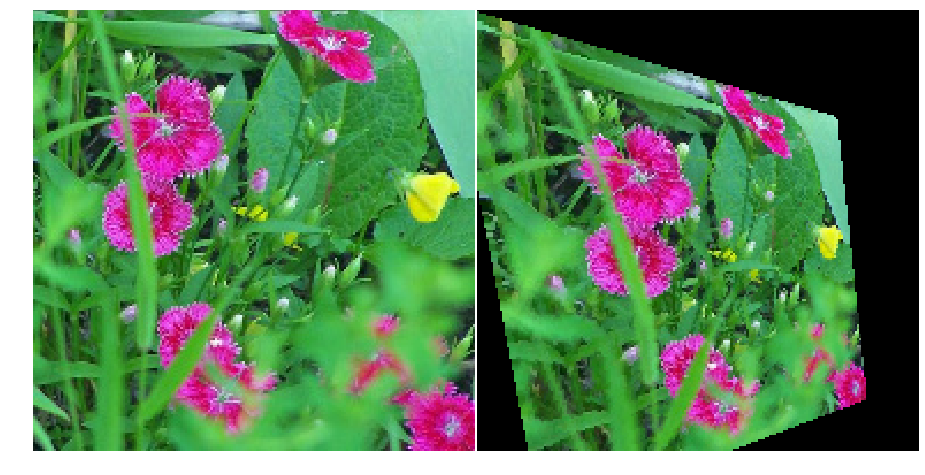

## Play with perspective transformation in JavaScript<a id='play-pers-trans'></a>

The code here is from the [javascript implementation](http://jsfiddle.net/dFrHS/1/) which I found through the discussion in [Computing a projective transformation](https://math.stackexchange.com/a/339033/33138).

You can move the 4 corners to play with perspective transformation!

In [ ]:
import IPython
IPython.display.IFrame("//jsfiddle.net/dFrHS/1/embedded/result,js,html,css", width=700, height=500)

## Implement perspective transformation in TensorFlow (batch)<a id='imp-pers-trans'></a>

In [ ]:
def random_4_points_2D_batch(height, width, batch_size, probability=1.0):
    """Generate `batch_size * 4` random 2-D points.
    
    Each 4 points are inside a rectangle with the same center as the above rectangle
    but with side length being approximately 1.5 times. This choice is to avoid the
    image being transformed too disruptively.

    Each point is created first by making it close to the corresponding corner points
    determined by the rectangle, i.e [0, 0], [0, width], [height, width] and [height, 0]
    respectively. Then the 4 points are randomly shifted module 4 and randomly flipped.
    
    Args:
        height: 0-D tensor, height of a reference rectangle.
        width: 0-D tensor, width of a reference rectangle.
        batch_size: 0-D tensor, the number of 4 points to be generated.
        probability: 0-D tensor, the probability to use perspective transformation.
        
    Returns:
        points: 3-D tensor of shape [batch_size, 4, 2]
    """

    probability = tf.constant(probability, dtype=tf.float32)
    
    sy = height // 4
    sx = width // 4
        
    h, w = height, width
    
    # Each has shape [batch_size]
    y1 = tf.random.uniform(minval = -sy, maxval = sy, shape=[batch_size], dtype=tf.int32)
    x1 = tf.random.uniform(minval = -sx, maxval = sx, shape=[batch_size], dtype=tf.int32)

    y2 = tf.random.uniform(minval = -sy, maxval = sy, shape=[batch_size], dtype=tf.int32)
    x2 = tf.random.uniform(minval = 3 * sx, maxval = 5 * sx, shape=[batch_size], dtype=tf.int32)

    y3 = tf.random.uniform(minval = 3 * sy, maxval = 5 * sy, shape=[batch_size], dtype=tf.int32)
    x3 = tf.random.uniform(minval = 3 * sx, maxval = 5 * sx, shape=[batch_size], dtype=tf.int32)    

    y4 = tf.random.uniform(minval = 3 * sy, maxval = 5 * sy, shape=[batch_size], dtype=tf.int32)
    x4 = tf.random.uniform(minval = -sx, maxval = sx, shape=[batch_size], dtype=tf.int32)
        
    # shape = [4, 2, batch_size]
    _points = tf.convert_to_tensor([[y1, x1], [y2, x2], [y3, x3], [y4, x4]])
    
    # shape = [batch_size, 4, 2]
    #     Each _points[i, :, :] consists of 4 points
    #         [y1, x1], [y2, x2], [y3, x3], [y4, x4],
    #     with xj, yj as scalars this time.
    _points = tf.transpose(_points, perm=[2, 0, 1])
    
    # shape = [4, 2]
    _standard_points = tf.constant([[0, 0], [0, width], [height, width], [height, 0]], dtype=tf.int32)
    # shape = [batch_size, 4, 2]
    _standard_points = tf.broadcast_to(_standard_points[tf.newaxis, :, :], shape=[batch_size, 4, 2])
    
    # If to use perspective transformation
    # shape = [batch_size, 1, 1]
    do_perspective = tf.cast(tf.random.uniform(shape=[batch_size]) < probability, dtype=tf.int32)[:, tf.newaxis, tf.newaxis]
    
    # shape = [batch_size, 4, 2]
    _points = do_perspective * _points + (1 - do_perspective) * _standard_points
    
    # ----------------------------------------
    # Trick to get random rotations
    
    # shape = [batch_size]
    # shift degree
    shift_degree = tf.random.uniform(minval=0, maxval=4, shape=[batch_size], dtype=tf.int32)
    
    # shape = [batch_size, 4]
    # Each `_indices[i, :]` is [0, 1, 2, 3] + a random integer in [0, 1, 2, 3]
    # This shifts the indices of the 4 points, which corresponds to a rotation.
    _indices = shift_degree[:, tf.newaxis] + tf.range(4, dtype=tf.int32)[tf.newaxis, :]
    _indices = tf.math.floormod(_indices, 4)

    # shape = [batch_size, 4, 2]
    # Each `indices[i, :, 0]` is [i, i, i, i]
    # Each `indices[i, :, :]` is [[i, k1], [i, k2] [i, k3], [i, k4]] where [k0, k1, k2, k3] is `_indices[i]`.
    _indices = tf.stack(
        [
            tf.broadcast_to(
                tf.range(batch_size, dtype=tf.int32)[:, tf.newaxis],
                shape=[batch_size, 4]
            ),
            _indices
        ],
        axis=2
    )

    # Obtain a tensor `new _points` of shape [batch_size, 4, 2], where
    # `new _points[i, j] = _points[indices[i, j]]`
    
    # shape = [batch_size, 4, 2]
    _points = tf.gather_nd(_points, _indices)
      
    # ----------------------------------------
    # Trick to get random reflections
    
    # All has shape [4]
    # no reflection
    reflection_0 = tf.constant([0, 1, 2, 3], dtype=tf.int32)
    # flip up/down
    reflection_1 = tf.constant([3, 2, 1, 0], dtype=tf.int32)
    # flip left/right
    reflection_2 = tf.constant([1, 0, 3, 2], dtype=tf.int32)
    
    # shape = [3, 4]
    reflections = tf.stack([reflection_0, reflection_1, reflection_2], axis=0)
    
    # shape = [batch_size, 3]
    reflection_types = tf.cast(
        tf.one_hot(
            tf.random.uniform(
                minval=0, maxval=3, shape=[batch_size], dtype=tf.int32
            ),
            3
        ),
        dtype=tf.int32
    )

    # shape = [batch_size, 4]
    selected_reflections = tf.linalg.matmul(reflection_types, reflections)
        
    # shape = [batch_size, 4, 2]
    _indices = tf.stack(
        [
            tf.broadcast_to(
                tf.range(batch_size, dtype=tf.int32)[:, tf.newaxis],
                shape=[batch_size, 4]
            ),
            selected_reflections
        ],
        axis=2
    )
            
    # shape = [batch_size, 4, 2]
    _points = tf.gather_nd(_points, _indices)
    
    # ----------------------------------------
    
    return _points


def random_4_point_transform_2D_batch(images, probability=1.0):
    """Apply 4 point transformation on 2-D images `images` with randomly
       generated 4 points on target spaces.
    
    On source space, the 4 points are the corner points, i.e [0, 0], [0, width],
    [height, width] and [height, 0].
    
    On target space, the 4 points are randomly generated by `random_4_points_2D_batch()`.
    """

    batch_size, height, width = images.shape[:3]

    # 4 corner points in source image
    # shape = [batch_size, 4, 2]
    src_pts = tf.convert_to_tensor([[0, 0], [0, width], [height, width], [height, 0]])
    src_pts = tf.broadcast_to(src_pts, shape=[batch_size, 4, 2])

    # 4 points in target image
    # shape = [batch_size, 4, 2]
    tgt_pts = random_4_points_2D_batch(height, width, batch_size, probability=probability)
    
    tgt_images = four_point_transform_2D_batch(images, src_pts, tgt_pts)

    return tgt_images


def four_point_transform_2D_batch(images, src_pts, tgt_pts):
    """Apply 4 point transformation determined by `src_pts` and `tgt_pts`
       on 2-D images `images`.
    
    Args:
        images: 3-D tensor of shape [batch_size, height, width], or 4-D tensor
            of shape [batch_size, height, width, channels]
        src_pts: 3-D tensor of shape [batch_size, 4, 2]
        tgt_pts: 3-D tensor of shape [batch_size, 4, 2]
        
    Returns:
        A tensor with the same shape as `images`.
    """
    
    src_to_tgt_mat = get_src_to_tgt_mat_2D_batch(src_pts, tgt_pts)
    
    tgt_images = transform_by_perspective_matrix_2D_batch(images, src_to_tgt_mat)
    
    return tgt_images


def transform_by_perspective_matrix_2D_batch(images, src_to_tgt_mat):
    """Transform 2-D images by prespective transformation matrices
    
    Args:
        images: 3-D tensor of shape [batch_size, height, width], or 4-D tensor of
            shape [batch_size, height, width, channels]
        src_to_tgt_mat: 3-D tensor of shape [batch_size, 3, 3]. This is the
            transformation matrix mapping the source space to the target space.
        
    Returns:
        A tensor with the same shape as `image`.        
    """

    batch_size, height, width = images.shape[:3]

    # shape = (3, 3)
    tgt_to_src_mat = tf.linalg.inv(src_to_tgt_mat)
        
    # prepare y coordinates
    # shape = [height * width]
    ys = tf.repeat(tf.range(height), width) 
    
    # prepare x coordinates
    # shape = [height * width]
    xs = tf.tile(tf.range(width), [height])

    # prepare indices in target space
    # shape = [2, height * width]
    tgt_indices = tf.stack([ys, xs], axis=0)
    
    # Change to projective coordinates in the target space by adding ones
    # shape = [3, height * width]
    tgt_indices_homo = tf.concat([tgt_indices, tf.ones(shape=[1, height * width], dtype=tf.int32)], axis=0)
    
    # Get the corresponding projective coordinate in the source space
    # shape = [batch_size, 3, height * width]
    src_indices_homo = tf.linalg.matmul(tgt_to_src_mat, tf.cast(tgt_indices_homo, dtype=tf.float64))
    
    # normalize the projective coordinates
    # shape = [batch_size, 3, height * width]
    src_indices_normalized = src_indices_homo[:, :3, :] / src_indices_homo[:, 2:, :]
    
    # Get the affine coordinate by removing ones
    # shape = [batch_size, 2, height * width]
    src_indices_affine = tf.cast(src_indices_normalized, dtype=tf.int32)[:, :2, :]
    
    # Mask the points outside the range
    # shape = [batch_size, height * width]
    y_mask = tf.logical_and(src_indices_affine[:, 0] >= 0, src_indices_affine[:, 0] <= height - 1)
    x_mask = tf.logical_and(src_indices_affine[:, 1] >= 0, src_indices_affine[:, 1] <= width - 1)
    mask = tf.logical_and(y_mask, x_mask)
    
    # clip the coordinates
    # shape = [batch_size, 2, height * width]
    src_indices = tf.clip_by_value(src_indices_affine, clip_value_min=0, clip_value_max=[[height - 1], [width - 1]])
    
    # Get a collection of (y_coord, x_coord)
    # shape = [batch_size, height * width, 2]
    src_indices = tf.transpose(src_indices, perm=[0, 2, 1])
    
    # shape = [batch_size, height * width, channels]
    tgt_images = tf.gather_nd(images, src_indices, batch_dims=1)
    
    # Set pixel to 0 by using the mask
    tgt_images = tgt_images * tf.cast(mask[:, :, tf.newaxis], tf.float32)
    
    # reshape to [height, width, channels]
    tgt_images = tf.reshape(tgt_images, images.shape)

    return tgt_images


def get_src_to_tgt_mat_2D_batch(src_pts, tgt_pts):
    """Get the perspective transformation matrix from the source space to the target space,
       which maps the 4 source points to the 4 target points.
    
    Args:
        src_pts: 3-D tensor of shape [batch_size, 4, 2]
        tgt_pts: 3-D tensor of shape [batch_size, 4, 2]
        
    Returns:
        3-D tensor of shape [batch_size, 3, 3]
    """
    
    src_pts = tf.cast(src_pts, tf.int32)
    tgt_pts = tf.cast(tgt_pts, tf.int32)
    
    # The perspective transformation matrix mapping basis vectors and (1, 1, 1) to `src_pts`
    # shape = [batch_size, 3, 3]
    src_mat = get_transformation_mat_2D_batch(src_pts)
    
    # The perspective transformation matrix mapping basis vectors and (1, 1, 1) to `tgt_pts`
    # shape = [batch_size, 3, 3]
    tgt_mat = get_transformation_mat_2D_batch(tgt_pts)
    
    # The perspective transformation matrix mapping `src_pts` to `tgt_pts`
    # shape = [batch_size, 3, 3]
    src_to_tgt_mat = tf.linalg.matmul(tgt_mat, tf.linalg.inv(src_mat))
    
    return src_to_tgt_mat
  
    
def get_transformation_mat_2D_batch(four_pts):
    """Get the perspective transformation matrix from a space to another space,
       which maps the basis vectors and (1, 1, 1) to the 4 points defined by `four_pts`.
    
    Args:
        four_pts: 3-D tensor of shape [batch_size, 4, 2]
        
    Returns:
        3-D tensor of shape [batch_size, 3, 3]        
    """
    
    batch_size = four_pts.shape[0]
    
    # Change to projective coordinates by adding ones
    # shape = [batch_size, 3, 4]
    pts_homo = tf.transpose(tf.concat([four_pts, tf.ones(shape=[batch_size, 4, 1], dtype=tf.int32)], axis=-1), perm=[0, 2, 1])
    
    pts_homo = tf.cast(pts_homo, tf.float64)
    
    # Find `scalars` such that: src_pts_homo[:, 3:] * scalars == src_pts_homo[:, 3:]
    # shape = [batch_size 3, 3]
    inv_mat = tf.linalg.inv(pts_homo[:, :, :3])
    # shape = [batch_size, 3, 1]
    scalars = tf.linalg.matmul(inv_mat, pts_homo[:, :, 3:])
    
    # Get the matrix transforming unit vectors to the 4 source points
    # shape = [batch_size, 3, 3]    
    mat = tf.transpose(tf.transpose(pts_homo[:, :, :3], perm=[0, 2, 1]) * scalars, perm=[0, 2, 1])
    
    return mat

def perspective_transform(images, labels, probability=1.0):
    """
    This is the method used for dataset transformation (random perspective transformation on images).
    """
        
    transformed_images = random_4_point_transform_2D_batch(images, probability=probability)
    
    return transformed_images, labels

## Visualize perspective transformation<a id='visu-pers-trans'></a>

In [ ]:
train_dataset = get_training_dataset(batch_size=16, shuffle_buffer_size=1, ordered=True)
train_iter = iter(train_dataset)

transformed_train_dataset = train_dataset.map(lambda images, labels: perspective_transform(images, labels, probability=0.8))
transformed_train_iter = iter(transformed_train_dataset)

In [ ]:
# run this cell again for next set of images
batch = next(train_iter)
transformed_batch = next(transformed_train_iter)

display_pairs_of_image_batch(batch, transformed_batch, ds_name_1='original dataset', ds_name_2='transformed dataset')

### Train with data augmentation

In [ ]:
trainer = Flower_Trainer(
    batch_size_per_replica=16, prediction_batch_size_per_replica=64, shuffle_buffer_size=None,
    oversample=True, target_counting=300, grad_acc_steps=8, augmentation_fn=perspective_transform,
    probability=0.35, log_interval=log_interval
)

In [ ]:
history_8, valid_labels, valid_preds = trainer.train(train_name='with data augmentation', model_name=model_name, epochs=epochs, start_lr=1e-5, max_lr=1e-5, end_lr=1e-5, warmup=0.2, lr_scaling=lr_scaling, optimized_loop=True, verbose=False)

#### without data augmentation vs. with data augmentation

In [ ]:
plot_history_pair(history_6, history_8, desc_1=f'[without data augmentation]', desc_2=f'[with data augmentation]', short_desc_1='no data aug.', short_desc_2=f'data aug.')

In [ ]:
print('results of the last epoch\n')

print('    without data augmentation:\n')

print('        valid recall:', history_6[len(history_6) - 1]['valid recall'])
print('        valid precision:', history_6[len(history_6) - 1]['valid precision'])
print('        valid f1:', history_6[len(history_6) - 1]['valid f1'])

print('\n    with data augmentation:\n')

print('        valid recall:', history_8[len(history_8) - 1]['valid recall'])
print('        valid precision:', history_8[len(history_8) - 1]['valid precision'])
print('        valid f1:', history_8[len(history_8) - 1]['valid f1'])

Our perspecitve transformation as data augmentation helps the model to perform slightly better on the validation dataset.
However, this might depends on a lot of factors, including the model architecture, model size, image size, etc. Also, our perspective transformation introduces black regions in the images, which might be another factor that affects the model performance. We leave the readers to explore different image augmentation methods by themselves. See the references for some notebooks about data augmentation.

With [TensorFlow 2.3](https://blog.tensorflow.org/2020/07/whats-new-in-tensorflow-2-3.html), we have the new layer [tf.keras.layers.experimental.preprocessing.RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation) that can perform random rotation for us!

**References**<a id='ref-aug'></a>
1. [CutMix and MixUp on GPU/TPU](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)
2. [Rotation Augmentation GPU/TPU - [0.96+]](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96)
3. [Make Chris Deotte's data augmentation faster](https://www.kaggle.com/yihdarshieh/make-chris-deotte-s-data-augmentation-faster)
4. [batch implementation of more data augmentations](https://www.kaggle.com/yihdarshieh/batch-implementation-of-more-data-augmentations)
5. [GridMask data augmentation with tensorflow](https://www.kaggle.com/xiejialun/gridmask-data-augmentation-with-tensorflow)
6. [Flower with TPUs - Advanced augmentations](https://www.kaggle.com/dimitreoliveira/flower-with-tpus-advanced-augmentations)

# Conclusion<a id='conclusion'></a>

In this notebook, we went through a custom training with TPUs. We learned about datase pipeline, oversampling, distributed dataset and distributed computation. We also saw how to define the loss values correctly, how to collect the return values from TPUs and a way to optimize the training time. A minimal implementation of gradient accumulation is provided for working with TPUs. We also showed a unusual data augmentation - perspective transformation. Finally, we performed several training and compared their results.

I hope you enjoy reading this notebook and learn something new!